In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/soft computing/Assignment 2/'

In [ ]:
dataset_A = url + 'Dataset C.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'

In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [ ]:
batch_size = 90
num_iters = 42000
input_dim = 28*28
num_hidden = 300
output_dim = 10

learning_rate = 0.09

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

148


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:216
Test dataloader:54


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=300, out_features=300, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=300, out_features=300, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=300, out_features=300, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=300, out_features=300, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=300, out_features=300, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=300, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Iteration: 500. Loss: 2.3002102375030518. Accuracy: 10.125540234616176
Epoch:  4
Epoch:  5
Iteration: 1000. Loss: 2.3005714416503906. Accuracy: 9.240584482403786
Epoch:  6
Epoch:  7
Iteration: 1500. Loss: 2.3004159927368164. Accuracy: 9.508129244700555
Epoch:  8
Epoch:  9
Epoch:  10
Iteration: 2000. Loss: 2.301788568496704. Accuracy: 9.508129244700555
Epoch:  11
Epoch:  12
Iteration: 2500. Loss: 2.3168351650238037. Accuracy: 12.0395143033546
Epoch:  13
Epoch:  14
Iteration: 3000. Loss: 2.328906536102295. Accuracy: 10.146120600946697
Epoch:  15
Epoch:  16
Epoch:  17
Iteration: 3500. Loss: 2.2237162590026855. Accuracy: 13.150854085202717
Epoch:  18
Epoch:  19
Iteration: 4000. Loss: 2.1820287704467773. Accuracy: 20.41572339987652
Epoch:  20
Epoch:  21
Iteration: 4500. Loss: 2.135066032409668. Accuracy: 16.2173286684503
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 5000. Loss: 2.0951693058013916. Accuracy: 18.254784935171845
Epoch:  25
Epoch:  26
Iteration: 5500

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/soft computing/Assignment 2/model_base.pkl')

[2.3002102375030518, 2.3005714416503906, 2.3004159927368164, 2.301788568496704, 2.3168351650238037, 2.328906536102295, 2.2237162590026855, 2.1820287704467773, 2.135066032409668, 2.0951693058013916, 2.1087188720703125, 1.9212157726287842, 2.042285680770874, 2.266191244125366, 2.0337772369384766, 2.0391316413879395, 2.0927250385284424, 2.2566757202148438, 2.005557060241699, 1.7499206066131592, 1.940558671951294, 1.8316051959991455, 1.7146072387695312, 2.0264062881469727, 1.8655002117156982, 1.593327283859253, 1.3510637283325195, 1.7944989204406738, 1.593778133392334, 1.465344786643982, 1.457788109779358, 1.2330427169799805, 1.3103123903274536, 1.4636390209197998, 1.760934591293335, 1.1016591787338257, 1.090585470199585, 2.161834239959717, 1.165063500404358, 0.9506222009658813, 0.960940957069397, 0.8431963324546814, 0.7573756575584412, 0.6668026447296143, 0.8997626304626465, 0.5243056416511536, 0.900676965713501, 1.4873623847961426, 0.92644864320755, 0.6823495030403137, 0.8666448593139648

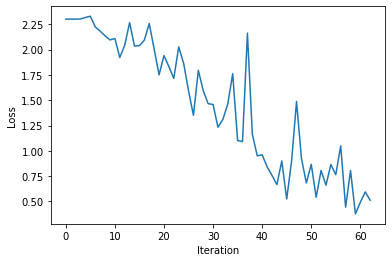

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()